In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from utils.analysis_helpers import *

from empath import Empath
lexicon = Empath()

In [4]:
directory = '../interviews_corrected/6_final/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_speaker_labels(df_all)

print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Found 82 CSV files.
Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [5]:
# Preoprocessing
# For the moment only focus on the participants answers
df = df_all[df_all["Speaker"] == "Participant"].copy()

# Select experiment
#df = df[df["Experiment"] == "OBE1"]

# Filter tokens (stopwords, punctuation, numeric values) were removed using the spacy library, 
# All text was lowercased + lemmatized,
# Plus extra_stopwords being the most frequents words in the corpus AND being meaningless 
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little", "actually",
    # Broad terms or context-specific words overshadowing subtler themes
    "part", "one", "sorry", "first", "second", #"meditation",
]
df['preprocessed_content'] = df['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords))

# Remove rows with empty content or content that's only punctuation after preprocessing
df = df[df['preprocessed_content'].str.strip().str.len() > 0]
# File S225 is removed because it is empty after preprocessing (only two utterances, not meaningful words for topics)

In [20]:
df = df.groupby(['Id']).agg({ #,"utterance_index"'File Name'
    'preprocessed_content': ' '.join,  # Combine preprocessed text
    'Content': ' '.join,  # Combine raw text
    'Experiment': 'first',   # Keep the first 
    'Condition': 'first',   # Keep the first
    #'Id': 'first',   # Keep the first
}).reset_index()

print(len(df))
df.head(2)

48


,Id,preprocessed_content,Content,Experiment,Condition
0,5,let unexpected surprising moment go realize ge...,"So, that was very, let's say, unexpected and s...",OBE1,1
1,7,explain come come crescendo stick right away r...,"I don't know how to explain that, but... I'm d...",OBE1,I


In [21]:
# Apply Empath analysis to the 'Content' column
df["Topic Scores"] = df["Content"].apply(lambda x: lexicon.analyze(x, normalize=True))

# Optionally, convert scores into separate columns
topic_df = pd.DataFrame(df["Topic Scores"].tolist())
df = pd.concat([df, topic_df], axis=1)

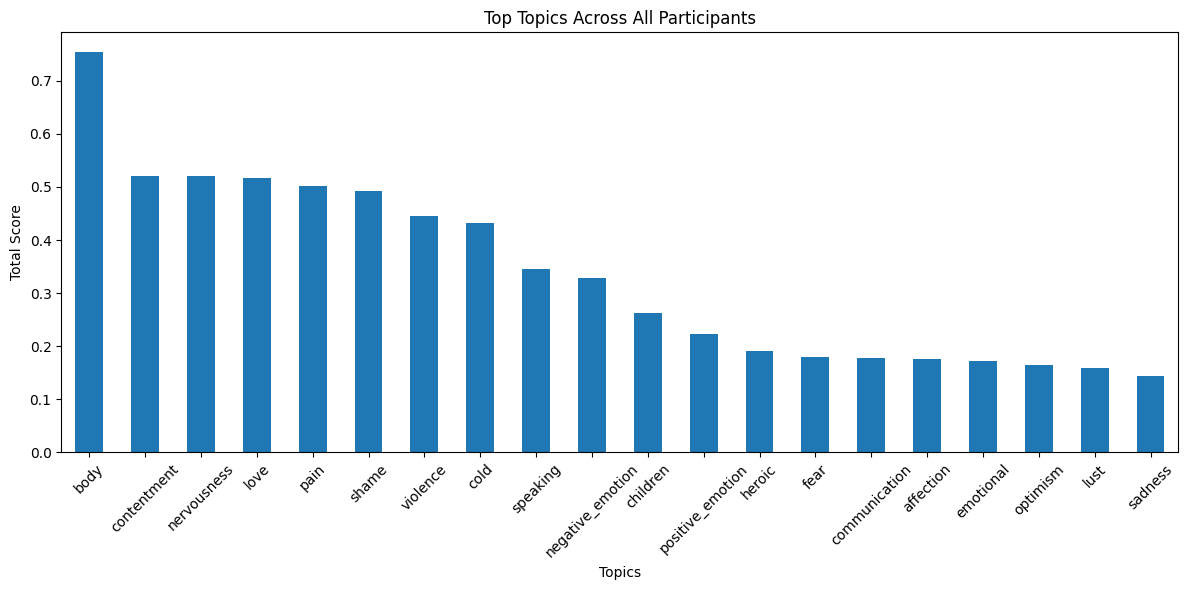

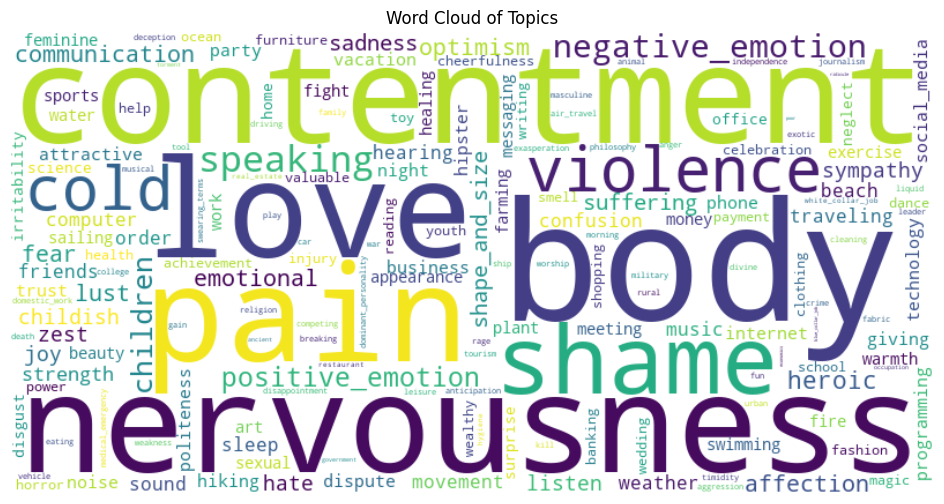

In [22]:
# Aggregate topic scores across all participants
topic_totals = pd.DataFrame(df["Topic Scores"].tolist()).sum().sort_values(ascending=False)

# Visualize top topics as a bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
topic_totals.head(20).plot(kind="bar")
plt.title("Top Topics Across All Participants")
plt.ylabel("Total Score")
plt.xlabel("Topics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Word cloud of top topics
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(topic_totals.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Topics")
plt.show()


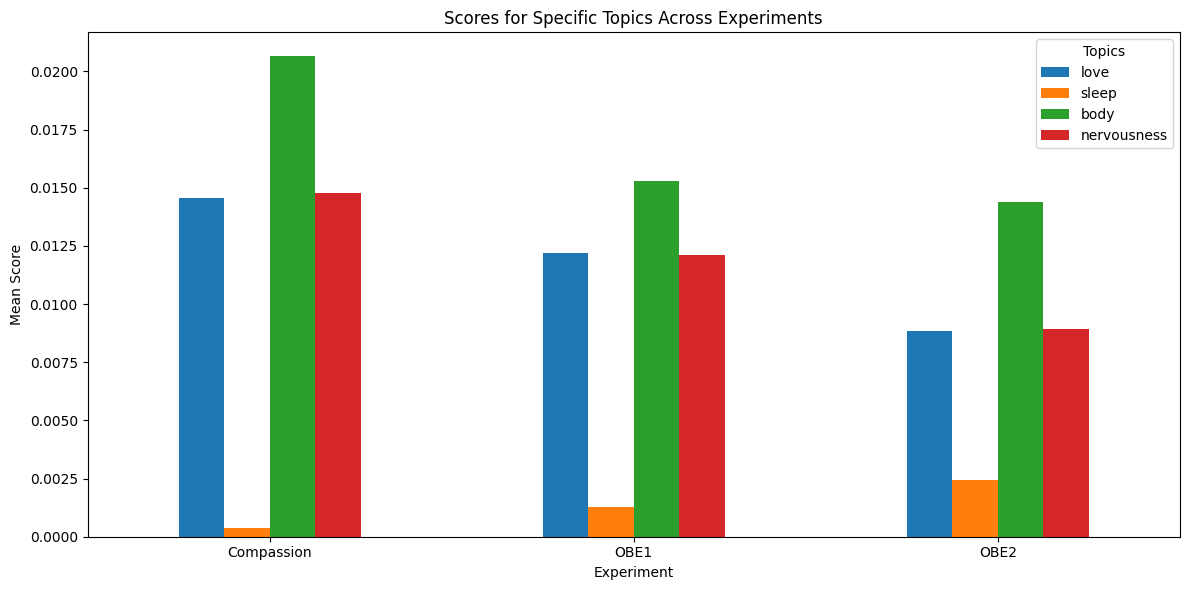

In [23]:
# Define topics of interest
specific_topics = ["love", "sleep", "body","nervousness"]

# Aggregate scores for selected topics by experiment
specific_topic_scores = df.groupby("Experiment")[specific_topics].mean()

# Visualize as bar chart
specific_topic_scores.plot(kind="bar", figsize=(12, 6))
plt.title("Scores for Specific Topics Across Experiments")
plt.ylabel("Mean Score")
plt.xlabel("Experiment")
plt.xticks(rotation=0)
plt.legend(title="Topics")
plt.tight_layout()
plt.show()

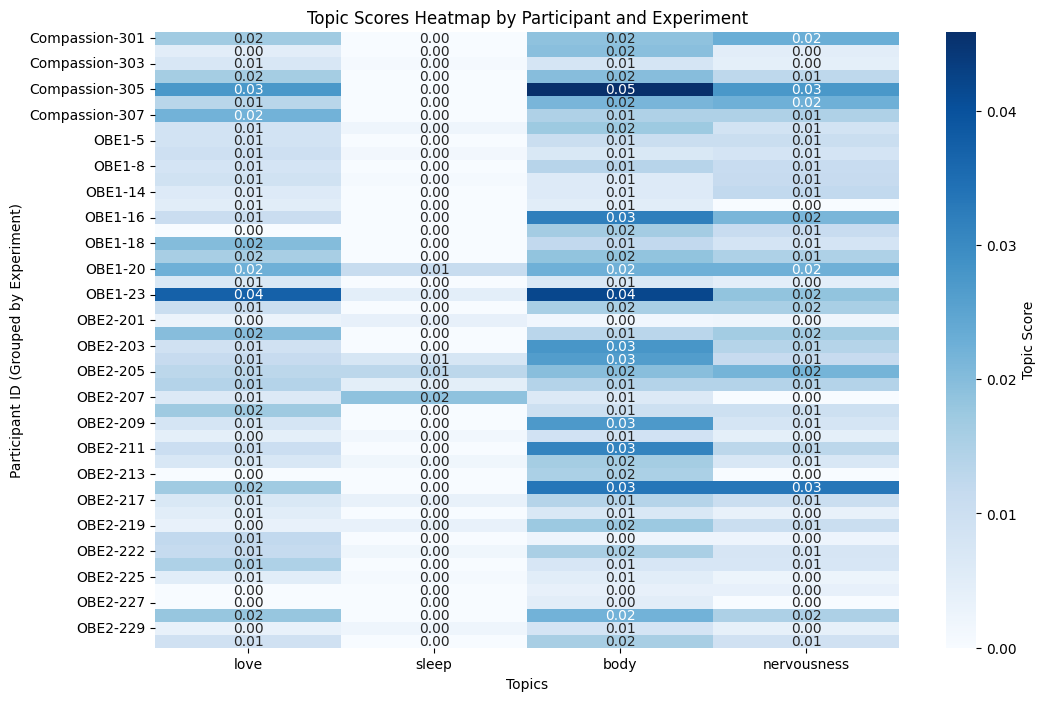

In [37]:
# Create a complete set of combinations of Experiment and Id
unique_combinations = (
    df[["Experiment", "Id"]].drop_duplicates().sort_values(["Experiment", "Id"])
)

# Merge with specific topics, filling missing values with 0
heatmap_data = unique_combinations.merge(
    df[["Id", "Experiment"] + specific_topics], how="left", on=["Id", "Experiment"]
).fillna(0)

# Pivot the table: rows = (Experiment, Id), columns = topics, values = topic scores
heatmap_pivot = heatmap_data.pivot_table(
    index=["Experiment", "Id"],  # Rows
    values=specific_topics,      # Columns = topic scores
    aggfunc="mean",              # Aggregate if multiple rows per participant
    fill_value=0                 # Fill missing values with 0
)

# Ensure data passed to heatmap is numeric
heatmap_pivot_numeric = heatmap_pivot[specific_topics]  # Select only topic columns

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_pivot_numeric,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Topic Score"}
)

# Customize the plot
plt.title("Topic Scores Heatmap by Participant and Experiment")
plt.xlabel("Topics")
plt.ylabel("Participant ID (Grouped by Experiment)")
plt.show()


In [10]:
# Aggregate topic scores across all participants
topic_totals = pd.DataFrame(df["Topic Scores"].tolist()).sum().sort_values(ascending=False)
topic_totals[0:30]

body                0.753203
contentment         0.523510
nervousness         0.523064
love                0.518636
pain                0.504905
shame               0.495174
violence            0.448588
cold                0.434208
speaking            0.351047
negative_emotion    0.325711
children            0.265882
positive_emotion    0.221947
heroic              0.191759
fear                0.178518
communication       0.176266
affection           0.175096
emotional           0.171862
optimism            0.162815
lust                0.157750
shape_and_size      0.144224
sadness             0.143009
suffering           0.140213
childish            0.132940
joy                 0.123970
hate                0.123101
sympathy            0.121942
zest                0.120084
listen              0.113113
strength            0.105281
order               0.097212
dtype: float64

In [11]:
# change the id to string instead of int
df['Id'] = df['Id'].astype(str)

# Mean topic scores by experiment
experiment_topic_means = df.groupby("Experiment").mean(numeric_only=True).reset_index()

# Max topic scores by experiment
experiment_topic_max = df.groupby("Experiment").max(numeric_only=True).reset_index()

# Median topic scores by experiment
experiment_topic_median = df.groupby("Experiment").median(numeric_only=True).reset_index()


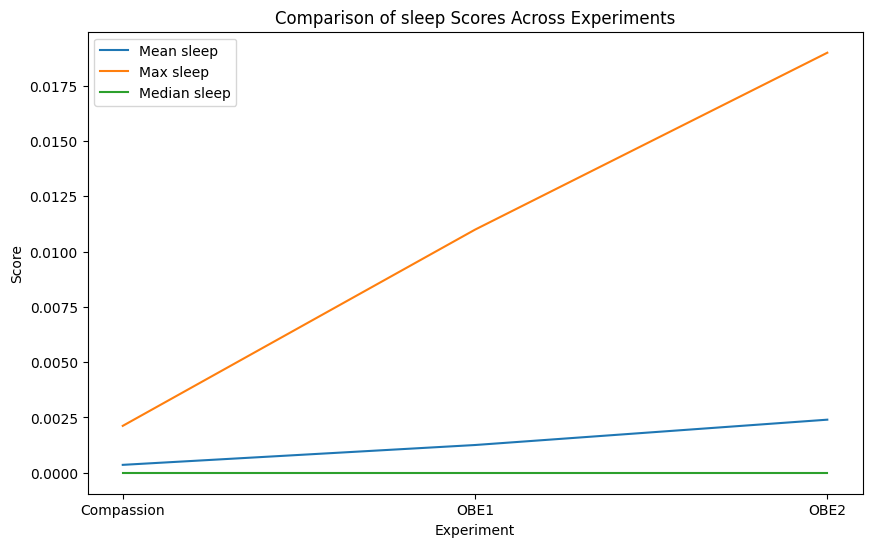

In [12]:
import matplotlib.pyplot as plt

# Combine all metrics for comparison
experiment_topic_agg = {
    "Mean": experiment_topic_means.set_index("Experiment"),
    "Max": experiment_topic_max.set_index("Experiment"),
    "Median": experiment_topic_median.set_index("Experiment"),
}

# Plot for a single topic
topic = "sleep"  # Replace with a topic of interest
plt.figure(figsize=(10, 6))
for agg_type, df_agg in experiment_topic_agg.items():
    plt.plot(df_agg[topic], label=f"{agg_type} {topic}")

plt.title(f"Comparison of {topic} Scores Across Experiments")
plt.ylabel("Score")
plt.xlabel("Experiment")
plt.legend()
plt.show()


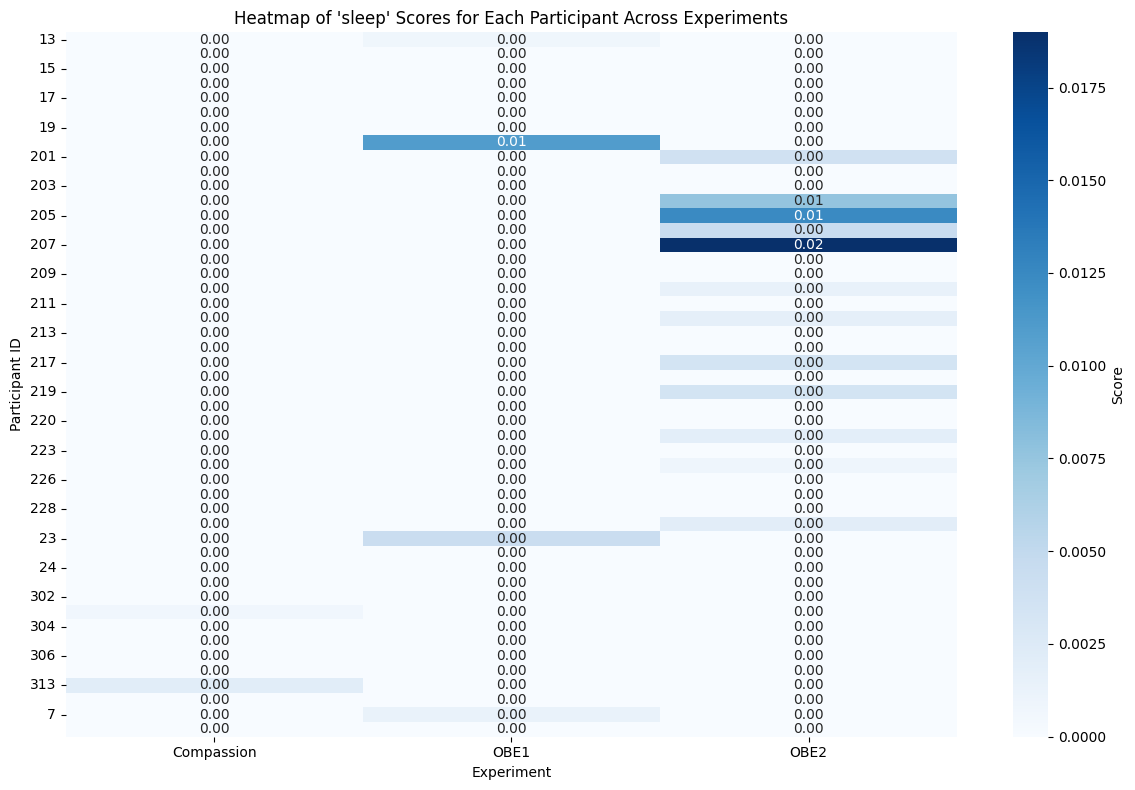

In [13]:
# Create a pivot table for heatmap
heatmap_data = df.pivot_table(
    index="Id",  # Rows represent participants
    columns="Experiment",  # Columns represent experiments
    values="sleep",  # Values are the topic scores
    fill_value=0  # Fill missing values with 0
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Score'})
plt.title(f"Heatmap of '{topic}' Scores for Each Participant Across Experiments")
plt.xlabel("Experiment")
plt.ylabel("Participant ID")
plt.tight_layout()
plt.show()


In [ ]:
scores, matched_words = lexicon.analyze(df.preprocessed_content[30],normalize=True, return_matches=True)

# show top 10 categories
sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]

In [ ]:
matched_words